Підготувати середовище для виконання лабораторної роботи (локальне чи Colab)

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.preprocessing import image
import time

In [8]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Завантажити дані для навчання (CIFAR10, див. методичні матеріали для готового фрагменту коду);

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [10]:
x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255

Відображення від номера класу до його назви

In [11]:
id2class = {
    idx: name for idx, name in enumerate([
        'airplane', 'automobile', 'bird',
        'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'
    ])
}

Візуалізація зображень

In [12]:
def display_cifar_images(
    x: np.ndarray,
    y: np.ndarray,
    id2class: dict[int, str],
    n: int = 4
):
    random_images_indices = np.random.randint(0, x.shape[0], n)
    images = x[random_images_indices]
    classes = [id2class[y[idx, 0]] for idx in random_images_indices]


    f, axs = plt.subplots(1, n, figsize=((3*n, 3)))
    for image, name, ax in zip(images, classes, axs):
        ax.imshow(image)
        ax.axis('off')
        ax.set(title=f"Class: {name}")
   
    plt.show()

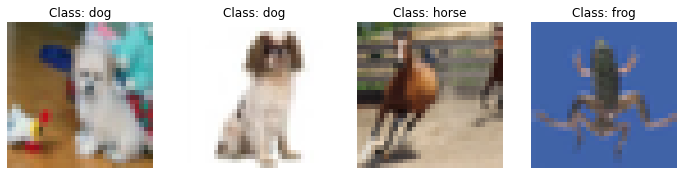

In [13]:
display_cifar_images(x_train, y_train, id2class)

## Навчити повнозв’язну нейронну мережу із запропонованою архітектурою (приклад з методичних матеріалів) та налаштуваннями компіляції:

Навчити мережу не змінюючи гіперпараметрів, заданих у прикладі;

Повнозв’язна мережа з Functional API

In [14]:
def construct_model(input_shape: tuple[int,...], dim_per_layer: list[int], n_classes: int) -> tf.keras.Model:
    input_x = tf.keras.layers.Input(shape=input_shape)


    x = tf.keras.layers.Flatten()(input_x)
    for dim in dim_per_layer:
        x = tf.keras.layers.Dense(dim, activation='relu')(x)

    out_x = tf.keras.layers.Dense(n_classes)(x) # можна додати activation = 'softmax'


    return tf.keras.Model(inputs=input_x, outputs=out_x)


model1 = construct_model((32,32,3), dim_per_layer=[100, 100], n_classes=len(id2class))

In [15]:
model1.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    # спарс версія оскільки y_train та y_test містять номери класів
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [16]:
time_start1 = time.perf_counter()
hist1 = model1.fit(
    x=x_train,
    y=y_train,
    # кількість епох
    epochs=100,
    # розмір партії даних
    batch_size=128,
    validation_data=(x_test, y_test)
)
time_end1 = time.perf_counter()


Epoch 1/100
391/391 [==============================] - 3s 6ms/step - loss: 2.0308 - accuracy: 0.2697 - val_loss: 1.9186 - val_accuracy: 0.2995
Epoch 2/100
391/391 [==============================] - 2s 5ms/step - loss: 1.8485 - accuracy: 0.3470 - val_loss: 1.8122 - val_accuracy: 0.3674
Epoch 3/100
391/391 [==============================] - 2s 4ms/step - loss: 1.7847 - accuracy: 0.3715 - val_loss: 1.7647 - val_accuracy: 0.3685
Epoch 4/100
391/391 [==============================] - 2s 4ms/step - loss: 1.7327 - accuracy: 0.3916 - val_loss: 1.7098 - val_accuracy: 0.4016
Epoch 5/100
391/391 [==============================] - 2s 5ms/step - loss: 1.6951 - accuracy: 0.4047 - val_loss: 1.6870 - val_accuracy: 0.4077
Epoch 6/100
391/391 [==============================] - 2s 4ms/step - loss: 1.6641 - accuracy: 0.4173 - val_loss: 1.6490 - val_accuracy: 0.4200
Epoch 7/100
391/391 [==============================] - 2s 4ms/step - loss: 1.6394 - accuracy: 0.4248 - val_loss: 1.6254 - val_accuracy: 0.4274

In [17]:
print('Час навчання моделі з початковими гіперпараметрами:', time_end1 - time_start1)

Час навчання моделі з початковими гіперпараметрами: 331.67782859999716


Оцінити метрики моделі на тестовій вибірці;

In [18]:
test_loss1, test_accuracy1 = model1.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 1.3865 - accuracy: 0.5205 - 814ms/epoch - 3ms/step


Побудувати криві навчання для моделі (для функції втрат та метрики точності);

In [19]:
def plot_history(history):
    plt.figure(figsize=(15,8))

    # Побудова кривої втрат
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Побудова кривої точності
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

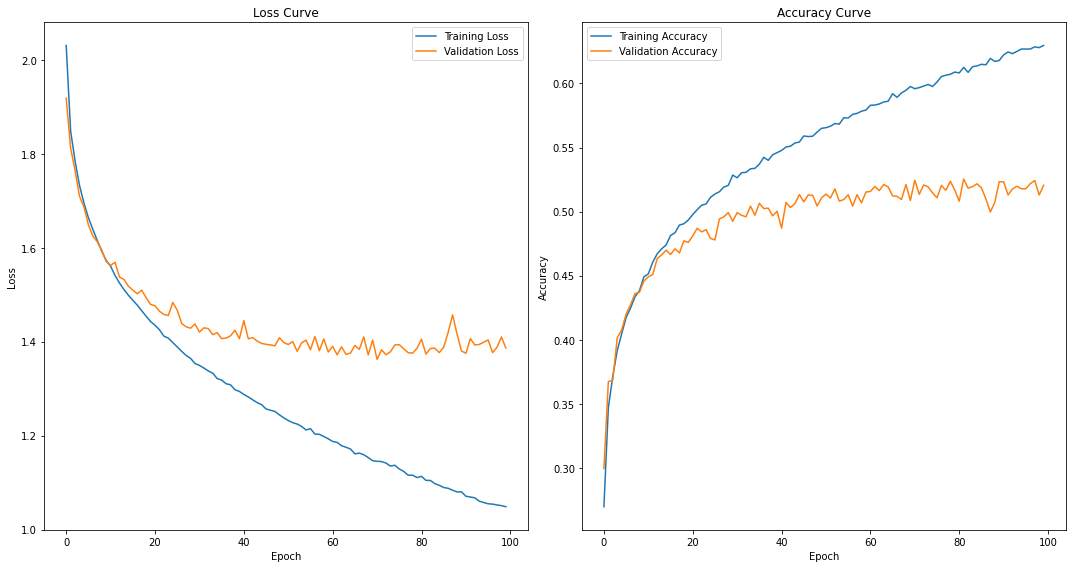

In [20]:
plot_history(hist1)

Побудувати classification_report та confusion_matrix для результатів моделі на тестовій виборці, зробити висновки;

In [21]:
# обчислення передбачуваних значень y
predictions1 = model1.predict(x_test)
# перетворення векторів прогнозів на мітки класів
y_pred1 = np.argmax(predictions1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [22]:
# матриця помилок
confusion_matrix(y_test, y_pred1)

array([[522,  40,  69,  20,  86,  12,  23,  29, 157,  42],
       [ 30, 655,  16,  22,  12,  10,  18,  31,  78, 128],
       [ 53,  20, 366,  74, 217,  66, 104,  63,  19,  18],
       [ 16,  20,  85, 318, 128, 157, 144,  69,  26,  37],
       [ 34,   8, 103,  40, 572,  37,  95,  79,  23,   9],
       [  8,  13,  91, 191, 117, 368,  79,  92,  18,  23],
       [ 10,  14,  58,  60, 176,  24, 603,  26,  15,  14],
       [ 19,  14,  56,  55, 121,  56,  33, 602,  15,  29],
       [ 60,  69,  19,  18,  52,  12,  17,  17, 688,  48],
       [ 33, 219,  16,  23,  31,  18,  20,  70,  59, 511]], dtype=int64)

In [23]:
# звіт класифікації
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.66      0.52      0.58      1000
           1       0.61      0.66      0.63      1000
           2       0.42      0.37      0.39      1000
           3       0.39      0.32      0.35      1000
           4       0.38      0.57      0.46      1000
           5       0.48      0.37      0.42      1000
           6       0.53      0.60      0.56      1000
           7       0.56      0.60      0.58      1000
           8       0.63      0.69      0.66      1000
           9       0.59      0.51      0.55      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.52     10000
weighted avg       0.53      0.52      0.52     10000



In [24]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 318410 (1.21 MB)
Trainable params: 318410 (1.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Змінюючи гіперпараметри, створити власну архітектуру повнозв’язної моделі

In [25]:
time_start2 = time.perf_counter()

model2 = construct_model((32,32,3), dim_per_layer=[1152, 576, 288], n_classes=len(id2class))

model2.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    # спарс версія оскільки y_train та y_test містять номери класів
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

hist2 = model2.fit(
    x=x_train,
    y=y_train,
    # кількість епох
    epochs=50,
    # розмір партії даних
    batch_size=32,
    validation_data=(x_test, y_test)
)

time_end2 = time.perf_counter()


Epoch 1/50
1563/1563 [==============================] - 37s 23ms/step - loss: 1.8340 - accuracy: 0.3451 - val_loss: 1.6735 - val_accuracy: 0.3972
Epoch 2/50
1563/1563 [==============================] - 39s 25ms/step - loss: 1.6354 - accuracy: 0.4183 - val_loss: 1.5686 - val_accuracy: 0.4506
Epoch 3/50
1563/1563 [==============================] - 37s 24ms/step - loss: 1.5457 - accuracy: 0.4512 - val_loss: 1.5113 - val_accuracy: 0.4641
Epoch 4/50
1563/1563 [==============================] - 39s 25ms/step - loss: 1.4844 - accuracy: 0.4746 - val_loss: 1.4673 - val_accuracy: 0.4804
Epoch 5/50
1563/1563 [==============================] - 44s 28ms/step - loss: 1.4371 - accuracy: 0.4901 - val_loss: 1.4746 - val_accuracy: 0.4728
Epoch 6/50
1563/1563 [==============================] - 47s 30ms/step - loss: 1.3939 - accuracy: 0.5065 - val_loss: 1.4454 - val_accuracy: 0.4874
Epoch 7/50
1563/1563 [==============================] - 48s 31ms/step - loss: 1.3554 - accuracy: 0.5204 - val_loss: 1.4072 -

| num_experiment | dim_per_layer | num_layer | epochs | batch_size | accuracy |
| :-: | :- | :-: | :-: | :-: | :-: |
| 1 | | | 25 | 32 | 0.5257 |
| 2 | | | 20 | 32 | 0.5282 |
| 3 |[1024, 512, 256] | 3 | 20 | 32 | 0.5445 |
| 4 |[1024, 512, 256, 128] | 4 | 20 | 32 | 0.5344 |
| 5 |[512, 256, 128] | 3 | 20 | 32 | 0.5252 |
| 6 |[256, 128] | 2 | 20 | 32 | 0.5183 |
| 7 |[1024, 512] | 2 | 20 | 32 | 0.5355 |
| 8 |[2048, 1024, 512] | 3 | 20 | 32 | 0.5374 |
| 9 |[2048, 1024, 512, 216] | 4 | 20 | 32 | 0.5349 |
| 10 |[1024, 512, 256] | 3 | 20 | 64 | 0.5338 |
| 11 |[1024, 512, 256] | 3 | 20 | 16 | 0.5428 |
| 12 |[900, 450, 225] | 3 | 20 | 32 | 0.5385 |
| 13 |[800, 400, 200] | 3 | 20 | 32 | 0.5286 |
| 14 |[800, 400, 200] | 3 | 20 | 128 | 0.5073 |
| 15 |[1024, 512, 256] | 3 | 40 | 32 | **0.5514** |
| 16 |[1024, 512, 256] | 3 | 30 | 32 | **0.5504** |
| 17 |[1024, 512, 256] | 3 | 30 | 16 | 0.5289 |
| 18 |[1024, 512, 256] | 3 | 45 | 32 | 0.5417 |
| 19 |[1024, 512, 256] | 3 | 30 | 64 | 0.5424 |
| 20 |[1152, 576, 288] | 3 | 30 | 32 | **0.5580** |
| 21 |[1024, 512, 256, 128] | 4 | 35 | 32 | 0.5281 |
| 22 |[1024, 768, 512] | 3 | 30 | 32 | 0.5445 |
| 23 |[960, 480, 240] | 3 | 30 | 48 | 0.5455 |
| 24 |[1024, 512, 256] | 3 | 20 | 48 | 0.5383 |
| 25 |[1152, 576, 288] | 3 | 35 | 32 | **0.5598** |
| 26 |[1152, 576, 288, 144] | 4 | 30 | 32 | **0.5560** |
| 27 |[1024, 512, 256] | 3 | 30 | 48 | 0.5329 |
| 28 |[1280, 640, 320] | 3 | 30 | 32 | 0.5474 |
| 29 |[1152, 576, 288] | 3 | 25 | 16 | 0.5409 |
| 30 |[1152, 576, 288] | 3 | 40 | 64 | 0.5396 |
| 31 |[1088, 544, 272] | 3 | 35 | 32 | 0.5393 |
| 32 |[1024, 512, 256] | 3 | 50 | 32 | 0.5464 |
| 33 |[1152, 576, 288] | 3 | 50 | 32 | **0.5608** |

In [26]:
print('Час навчання моделі зі зміненими гіперпараметрами:', time_end2 - time_start2)

Час навчання моделі зі зміненими гіперпараметрами: 2062.161785199998


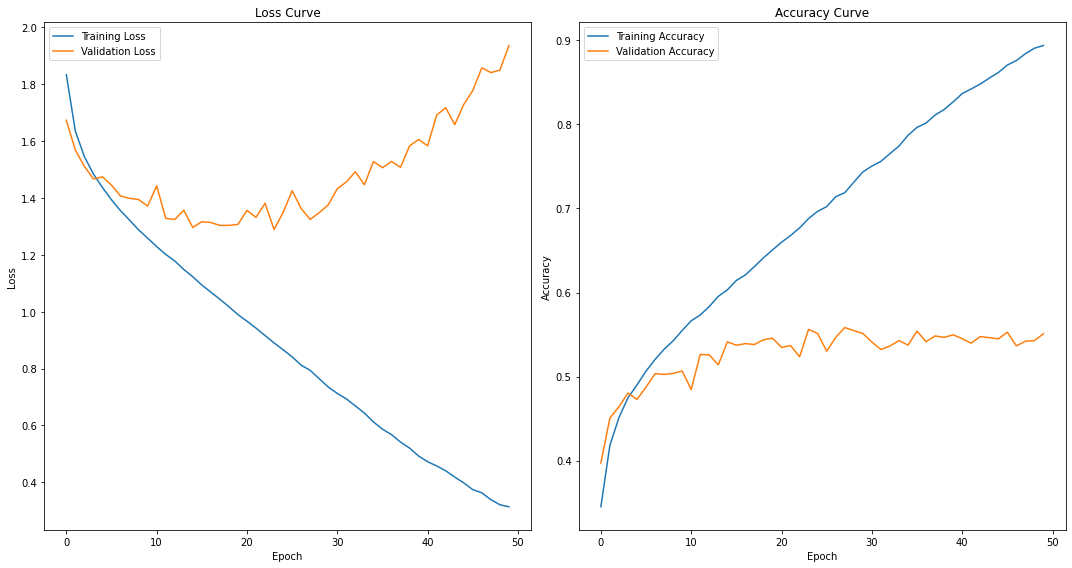

In [27]:
plot_history(hist2)

In [28]:
# обчислення передбачуваних значень y
predictions2 = model2.predict(x_test)
# перетворення векторів прогнозів на мітки класів
y_pred2 = np.argmax(predictions2, axis=1)

313/313 [==============================] - 2s 6ms/step


In [29]:
# матриця помилок
confusion_matrix(y_test, y_pred2)

array([[712,  31,  36,  22,  16,   6,  29,   6, 122,  20],
       [ 44, 692,  13,  29,  17,   6,  19,  14,  91,  75],
       [107,  18, 388, 150, 144,  36,  73,  45,  28,  11],
       [ 41,  22,  63, 551,  60,  72, 102,  45,  28,  16],
       [ 70,   9,  94, 109, 509,  18,  88,  58,  35,  10],
       [ 28,  11,  67, 365,  67, 296,  62,  63,  27,  14],
       [ 22,  21,  40, 145, 103,  20, 607,  13,  21,   8],
       [ 73,  14,  47, 114,  89,  35,  25, 558,  20,  25],
       [114,  52,  13,  37,  12,   2,   7,  12, 731,  20],
       [ 81, 201,  11,  60,  23,  11,  20,  38,  90, 465]], dtype=int64)

In [30]:
# звіт класифікації
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.55      0.71      0.62      1000
           1       0.65      0.69      0.67      1000
           2       0.50      0.39      0.44      1000
           3       0.35      0.55      0.43      1000
           4       0.49      0.51      0.50      1000
           5       0.59      0.30      0.39      1000
           6       0.59      0.61      0.60      1000
           7       0.65      0.56      0.60      1000
           8       0.61      0.73      0.67      1000
           9       0.70      0.47      0.56      1000

    accuracy                           0.55     10000
   macro avg       0.57      0.55      0.55     10000
weighted avg       0.57      0.55      0.55     10000



In [31]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 1152)              3540096   
                                                                 
 dense_4 (Dense)             (None, 576)               664128    
                                                                 
 dense_5 (Dense)             (None, 288)               166176    
                                                                 
 dense_6 (Dense)             (None, 10)                2890      
                                                                 
Total params: 4373290 (16.68 MB)
Trainable params: 4373290 

### Порівняти розміри моделей та час їх навчання;
1. Початкова модель - 331.677 s; 1.21 MB; accuracy - 0.5205
2. Змінена модель - 2062.161 s; 16.68 MB; accuracy - 0.5509

### Завантажити кілька зображень, що не належать до датасету, та зробити передбачення їх класу, використовуючи (останню) навчену модель.

In [32]:
def predict_image_class(img_path, model):
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    # додатковий вимір на початку масиву (32, 32, 3) -> (1, 32, 32, 3)
    img_array = np.expand_dims(img_array, axis=0) 
    # нормалізація 
    img_array /= 255.0 

    # використання моделі для класифікації зображення
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions, axis=1)
    
    # відображення номеру класу та його назви
    class_name = id2class[class_idx[0]]
    
    return class_name

In [33]:
predict_image_class(img_path=r'DL-LW1-test/test_automobile.jpg', model=model2)

1/1 [==============================] - 0s 36ms/step


'automobile'

In [34]:
predict_image_class(img_path=r'DL-LW1-test/test_cat.jpg', model=model2)

1/1 [==============================] - 0s 30ms/step


'cat'

In [35]:
predict_image_class(img_path=r'DL-LW1-test/test_dog.jpg', model=model2)

1/1 [==============================] - 0s 28ms/step


'deer'